## Урок 1. Кейс 1. EDA по Hourly Energy Consumption и Brent

#### 1. Выберите наборы данных. которые можно интерпретировать, как временные ряды:<br>
а) зависимость цены на недвижимость в конкретном регионе от времени,<br>
б) скорость полета самолета при перелете из аэропорта А в аэропорт В,<br>
в) количество отказов компьютера,<br>
г) число обращений в поликлинику по району,<br>
д) координаты автобуса при движении по маршруту,<br>
е) координаты фигуры нарушителя в файле видеофиксации охранной системы.<br>

#### Ответ

а) это временной ряд;<br>
б) если рассматривается скорость полёта в зависимости от времени, то да - можно интерпретировать как временной ряд, но если это просто скаляр, то нет;<br>
в) если рассматривается количество отказов компьютера в зависимости от времени, то да - можно интерпретировать как временной ряд, но если это просто скаляр, то нет;<br>
г) если рассматривается число обращений в поликлинику в зависимости от времени, то да - можно интерпретировать как временной ряд, но если это просто скаляр, то нет;<br>
д) если рассматриваются координаты автобуса в зависимости от времени, то да - можно интерпретировать как временной ряд, но если это просто скаляр, то нет;<br>
е) если рассматриваются координаты фигуры нарушителя в зависимости от времени, то да - можно интерпретировать как временной ряд, но если это просто скаляр, то нет.

#### 2. Прочитайте DUQ_hourly.csv и проверьте качество и порядок разметки этой выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США. Сделайте описание особенностей этой выборки.

In [119]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

In [120]:
data = pd.read_csv('DUQ_hourly.csv', index_col=[0], parse_dates=[0])
data.head()

,DUQ_MW
Datetime,
2005-12-31 01:00:00,1458.0
2005-12-31 02:00:00,1377.0
2005-12-31 03:00:00,1351.0
2005-12-31 04:00:00,1336.0
2005-12-31 05:00:00,1356.0


In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119068 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DUQ_MW  119068 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


In [122]:
# Посмотрим на характеристики нашего временного ряда в смысле основных статистик
data.describe()

,DUQ_MW
count,119068.000000
mean,1658.820296
std,301.740640
min,1014.000000
25%,1444.000000
50%,1630.000000
75%,1819.000000
max,3054.000000


In [123]:
# Поскольку данные лежат в диапазоне от 1014 до 3054, то очевидно, что точность представления float64 избыточна. 
# Перейдем к целым. Это позволит сократить объем занимаемой памяти.
data['DUQ_MW'] = data['DUQ_MW'].astype('int')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 119068 entries, 2005-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   DUQ_MW  119068 non-null  int32
dtypes: int32(1)
memory usage: 1.4 MB


In [124]:
# Проверим пропуски
data['DUQ_MW'].isnull().sum()

0

In [125]:
# Пропусков нет

Text(0, 0.5, 'МВт')

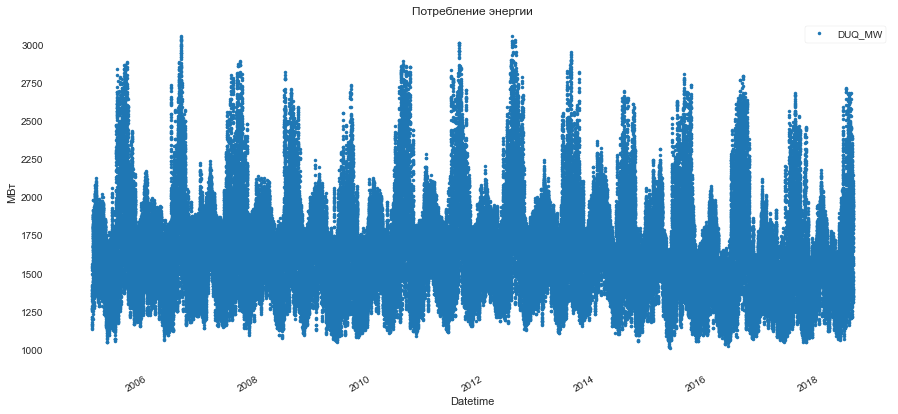

In [126]:
# Псотроим график
data.plot( style = '.', figsize = ( 15, 7 ), title = 'Потребление энергии' )
plt.ylabel ( 'МВт' )

In [127]:
# График довольно красивый, с выраженной сезонностью, никаких особых выбросов нет

In [128]:
# Рассмотрим поближе 2016 год
data['date'] = data.index
data_2016 = data.loc[np.logical_and(data['date'].dt.year == 2016, data['date'].dt.month == 10)]

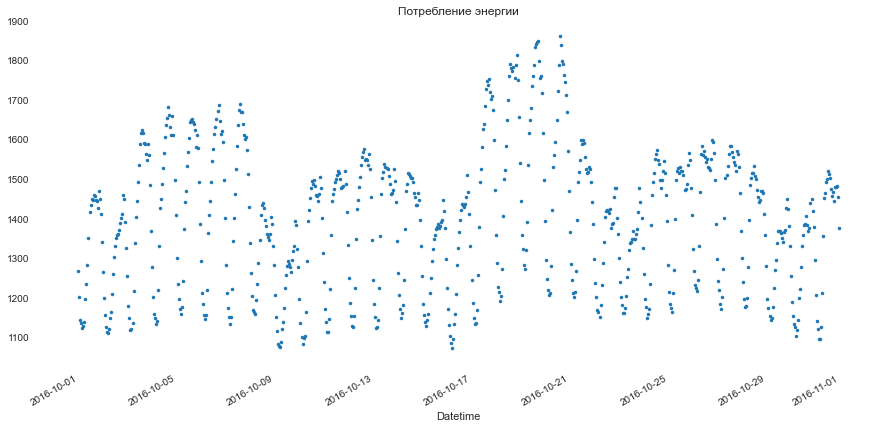

In [129]:
_ = data_2016['DUQ_MW'].plot( style='.', figsize=( 15, 7 ), title='Потребление энергии' )

In [130]:
# Тоже никаких особенностей не наблюдаем

In [131]:
# Посчитаем уникальные значения даты
ut = data['date'].unique()
print('число уникальных значений:', ut.shape[0], ', число наблюдений:', data.shape[0])

число уникальных значений: 119064 , число наблюдений: 119068


In [132]:
# Обращаем внимание, что количество уникальных значений для даты равно 119064, тогда как общее число строк 
# в выборке равно 119068. Значит есть задвоенные записи
# Посмотрим на эти дубли
data['date'].value_counts().head()

2017-11-05 02:00:00    2
2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
2007-07-15 10:00:00    1
Name: date, dtype: int64

In [133]:
# Видимо это ошибки при переходе на зимнее время
# Проверим март-апрель 2015 года

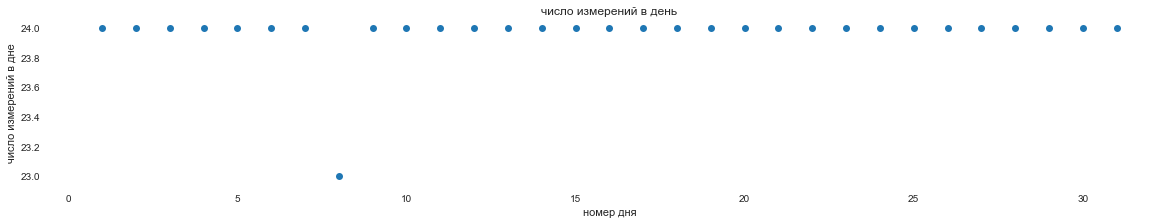

In [134]:
day_H=data['2015-03-01 00:00:00':'2015-03-31 23:00:00'].index.day

plt.figure(figsize=(20,3))
plt.plot(day_H.value_counts().index, day_H.value_counts().values ,'o')

plt.xlabel('номер дня')
plt.ylabel('число измерений в дне')
plt.title('число измерений в день')
plt.show()

In [135]:
# Видим, что один из дней марта имеет меньше измерений, чем остальные. 
# Определим номер этого дня используя подсчет числа измерений по дням и сравнение этой цифры с идеальным значением 24.

In [136]:
Day_count = day_H.value_counts() 
Day_count[Day_count != 24]

8    23
Name: Datetime, dtype: int64

In [137]:
# Посмотрим на этот день поближе

In [138]:
data['2015-03-08 01:00:00':'2015-03-08 06:00:00'].index

DatetimeIndex(['2015-03-08 01:00:00', '2015-03-08 02:00:00',
               '2015-03-08 04:00:00', '2015-03-08 05:00:00',
               '2015-03-08 06:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)

In [139]:
# После 2-го часа сразу наступил 4-й.

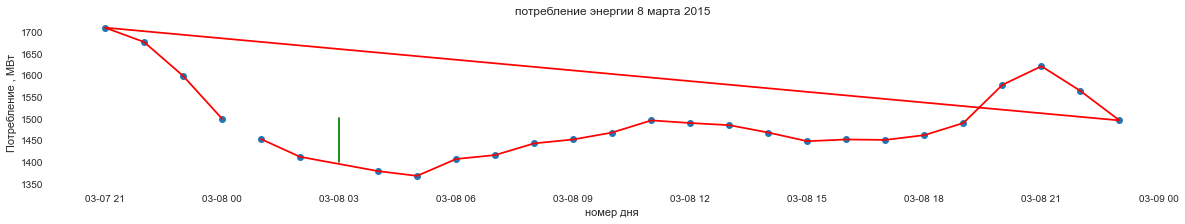

In [140]:
plt.figure(figsize=(20,3))
plt.plot(data['2015-03-07 21:00:00':'2015-03-8 23:00:00'].index,data['2015-03-07 21:00:00':'2015-03-08 23:00:00']['DUQ_MW'].values, 'o')
plt.plot(data['2015-03-07 21:00:00':'2015-03-8 23:00:00'].index,data['2015-03-07 21:00:00':'2015-03-08 23:00:00']['DUQ_MW'].values, 'r')
line_ = pd.to_datetime(pd.Series(['2015-03-08 03:00:00', '2015-03-08 03:00:00']))
plt.plot(line_,np.array([1400,1500]),'g')
plt.xlabel('номер дня')
plt.ylabel('Потребление , МВт')
plt.title('потребление энергии 8 марта 2015')

plt.show()

In [141]:
# Проблему с переходом на зимнее время можно решить, пользуясь какой-либо общей идеей.
# Например можно заполнить пропуск как среднее по 2-м соседям.

In [142]:
# Обратим внимание еще на один момент. На рисунке странное соединение точек: 23 часа соединены с 0 часов 8.03.2015. 
# Посмотрим на другие дни по такой же схеме.

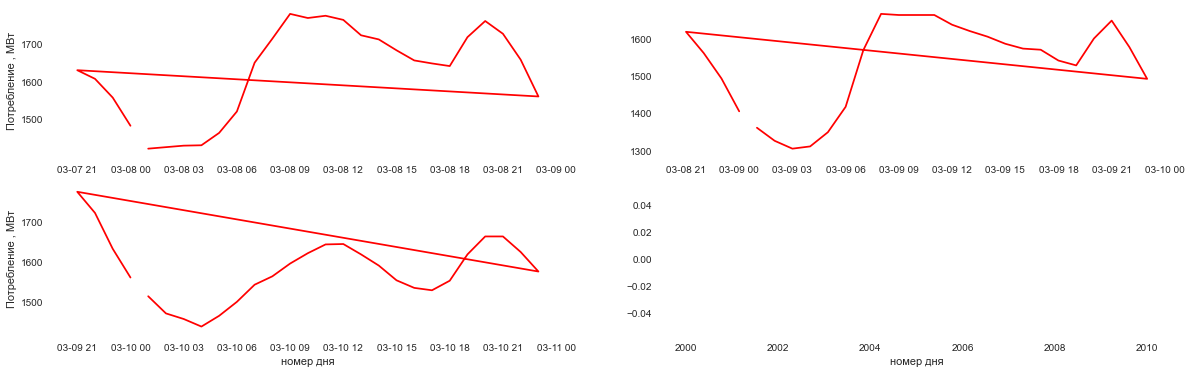

In [143]:
plt.figure(figsize=(20,6))
plt.subplot(2,2,1)
plt.plot(data['2010-03-07 21:00:00':'2010-03-8 23:00:00'].index,data['2010-03-07 21:00:00':'2010-03-08 23:00:00']['DUQ_MW'].values, 'r')
plt.ylabel('Потребление , МВт')

plt.subplot(2,2,2)
plt.plot(data['2015-03-08 21:00:00':'2015-03-9 23:00:00'].index,data['2015-03-08 21:00:00':'2015-03-09 23:00:00']['DUQ_MW'].values, 'r')

plt.subplot(2,2,3)
plt.plot(data['2012-03-09 21:00:00':'2012-03-10 23:00:00'].index,data['2012-03-09 21:00:00':'2012-03-10 23:00:00']['DUQ_MW'].values, 'r')
plt.ylabel('Потребление , МВт')
plt.xlabel('номер дня')

plt.subplot(2,2,4)
plt.plot(data['2003-03-10 21:00:00':'2003-03-11 23:00:00'].index,data['2003-03-10 21:00:00':'2003-03-11 23:00:00']['DUQ_MW'].values, 'r')
plt.xlabel('номер дня')

plt.show()

In [144]:
# Результат ревизии нескольких дней показывает, что это постоянная картина для всего ряда. 
# Причина в реверсивном способе дописывания дневных данных

In [145]:
data.iloc[19:26,:]

,DUQ_MW,date
Datetime,,
2005-12-31 20:00:00,1737,2005-12-31 20:00:00
2005-12-31 21:00:00,1726,2005-12-31 21:00:00
2005-12-31 22:00:00,1669,2005-12-31 22:00:00
2005-12-31 23:00:00,1592,2005-12-31 23:00:00
2006-01-01 00:00:00,1493,2006-01-01 00:00:00
2005-12-30 01:00:00,1484,2005-12-30 01:00:00
2005-12-30 02:00:00,1419,2005-12-30 02:00:00


In [146]:
# Данные от 2006-01-01 00:00:00 записаны между 31.12.2005 и 30.12.2005. 
# Принципиально при оценке статистики это не очень страшно, но порядок передачи информации важен, 
# когда мы начинаем рассматривать данные по порядку записи и отображать их на график. 
# Для исключения нарушения порядка необходимо провести сортировку по индексу время-дата.

#### 3. Прочитайте базу Brent и сделайте ее перерасчет (ресемплинг) в представление по неделям , по месяцам.

In [147]:
brent_data = pd.read_excel('нефть-brent 2010-2019.xlsx', index_col=[0], parse_dates=[0])

In [148]:
# Представление по неделям
brent_data_wm = brent_data.resample("W").mean()
brent_data_wm.head()

,Значение
Дата,
2010-09-05,76.616000
2010-09-12,77.673333
2010-09-19,78.693333
2010-09-26,78.518333
2010-10-03,81.211667


In [149]:
# Представление по месяцам
brent_data_mm = brent_data.resample("M").mean()
brent_data_mm.head()

,Значение
Дата,
2010-09-30,78.228148
2010-10-31,83.473462
2010-11-30,86.178077
2010-12-31,92.232308
2011-01-31,97.033200


#### 4. Постройте график изменения среднего по выборке и среднего отклонения по выборке на недельных, месячных и годовых группах для Brent.

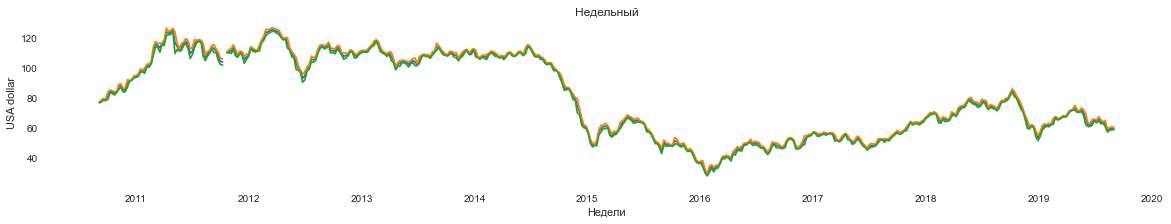

In [150]:
brent_data_wstd = brent_data.resample("W").std()
brent_data_wh = brent_data_wm + brent_data_wstd
brent_data_wl = brent_data_wm - brent_data_wstd

plt.figure(figsize=(20,3))
plt.plot(brent_data_wm)
plt.plot(brent_data_wh)
plt.plot(brent_data_wl)
plt.xlabel('Недели')
plt.ylabel('USA dollar')
plt.title('Недельный')
plt.show()

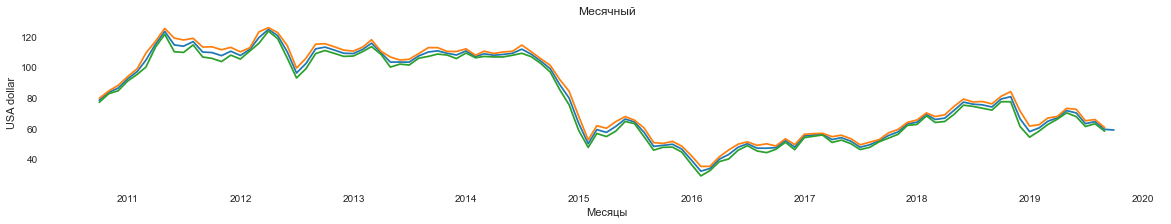

In [151]:
brent_data_mstd = brent_data.resample("M").std()
brent_data_mh = brent_data_mm + brent_data_mstd
brent_data_ml = brent_data_mm - brent_data_mstd

plt.figure(figsize=(20,3))
plt.plot(brent_data_mm)
plt.plot(brent_data_mh)
plt.plot(brent_data_ml)
plt.xlabel('Месяцы')
plt.ylabel('USA dollar')
plt.title('Месячный')
plt.show()

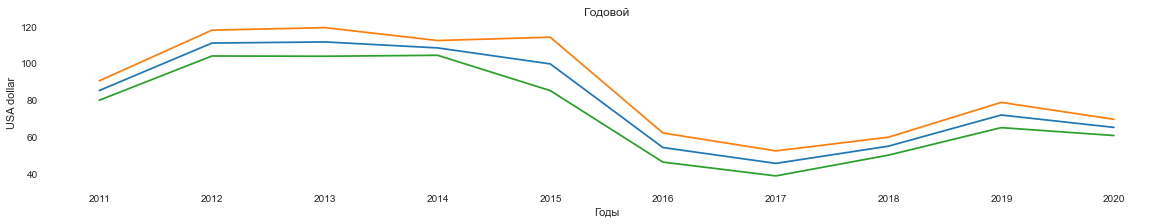

In [152]:
brent_data_ym = brent_data.resample("Y").mean()
brent_data_ystd = brent_data.resample("Y").std()
brent_data_yh = brent_data_ym + brent_data_ystd
brent_data_yl = brent_data_ym - brent_data_ystd

plt.figure(figsize=(20,3))
plt.plot(brent_data_ym)
plt.plot(brent_data_yh)
plt.plot(brent_data_yl)
plt.xlabel('Годы')
plt.ylabel('USA dollar')
plt.title('Годовой')
plt.show()

#### 5. Сделайте вывод о том, как изменилось поведение цены на недельных и месячных графиках по сравнению с дневными.

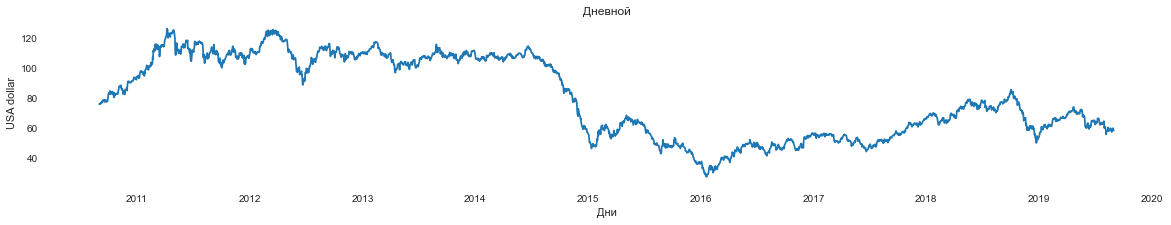

In [153]:
plt.figure(figsize=(20,3))
plt.plot(brent_data)
plt.xlabel('Дни')
plt.ylabel('USA dollar')
plt.title('Дневной')
plt.show()

In [154]:
# На недельных и месячных графиках цена более сглаженна по сравненнию с дневными